# Движење во матрица

## Референци

- [Растојание Чебишев](https://en.wikipedia.org/wiki/Chebyshev_distance)
- [Растојание Менхетен](https://en.wikipedia.org/wiki/Taxicab_geometry)
- [Растојание Евклид](https://en.wikipedia.org/wiki/Euclidean_distance)

In [84]:
import math
from collections import deque
import heapq
from plotly import graph_objects as go
import ipywidgets as widgets
from IPython.lib.display import YouTubeVideo

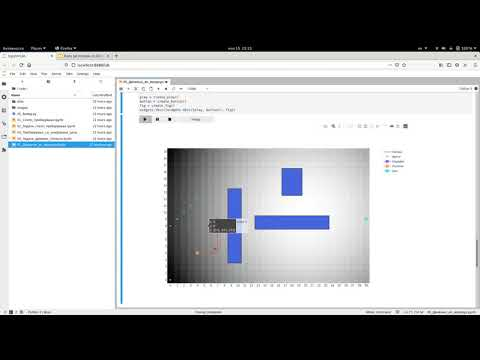

In [85]:
YouTubeVideo('O5hDX-pHDag')

## Параметри за светот во симулацијата

In [86]:
ROWS, COLUMNS = 20, 30
WALLS = [
    {'x': (12.5, 23.5), 'y': (7.5, 9.5)},
    {'x': (8.5, 10.5), 'y': (2.5, 13.5)},
    {'x': (16.5, 19.5), 'y': (12.5, 16.5)},
]

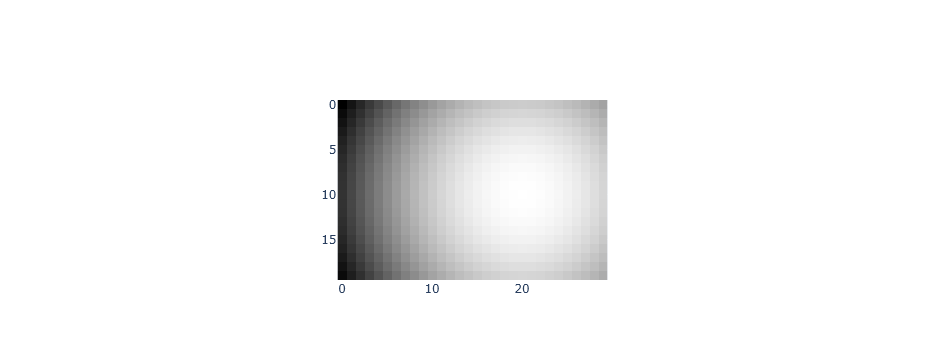

In [87]:
def create_mountain():
    def f(x, y):
        return 1 - (x - 2 * COLUMNS // 3) ** 2 - (y - ROWS // 2) ** 2

    mountain = [[f(x, y) for x in range(COLUMNS)] for y in range(ROWS)]
    min_value = min(min(mountain))
    for y in range(ROWS):
        for x in range(COLUMNS):
            mountain[y][x] = [mountain[y][x] - min_value] * 3

    min_value = min(min(min(mountain)))
    max_value = max(max(max(mountain)))
    mountain_image = go.Image(z=mountain, zmin=[min_value]*4, zmax=[max_value]*4)
    return mountain, mountain_image


MOUNTAIN, mountain_image = create_mountain()
go.Figure(mountain_image)

In [88]:
def get_weight(source_state, destination_state):
    """ Функцијата враќа колку е тешко да се движиме по планината, 
        односно тежини кај тежинскиот граф, 
        потребни за пребарувањата со униформна цена и А*
    """
    source_x, source_y = source_state
    destination_x, destination_y = destination_state
    weight = MOUNTAIN[destination_y][destination_x][0] - MOUNTAIN[source_y][source_x][0]
    return 1 + max(weight, 0)


get_weight((3, 4), (3, 5))

12

## Алгоритми за пребарување

### Пребарување прво по широчина

In [89]:
def breadth_first_search(starting_vertex, goal_vertex, expand_state):
    visited = {starting_vertex}
    queue = deque([[starting_vertex]])
    while queue:
        vertex_list = queue.popleft()
        vertex_to_expand = vertex_list[-1]

        frontier = list(set([q[-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state(vertex_to_expand):
            if neighbour not in visited:
                visited.add(neighbour)
                queue.append(vertex_list + [neighbour])
    yield [], [], goal_vertex

### Пребарување прво по длабочина

In [90]:
def depth_first_search(starting_vertex, goal_vertex, expand_state):
    visited = {starting_vertex}
    queue = deque([[starting_vertex]])
    while queue:
        vertex_list = queue.popleft()
        vertex_to_expand = vertex_list[-1]

        frontier = list(set([q[-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state(vertex_to_expand):
            if neighbour not in visited:
                visited.add(neighbour)
                queue.appendleft(vertex_list + [neighbour])
    yield [], [], goal_vertex

### Пребарување со униформна цена

In [91]:
def uniform_cost_search(starting_vertex, goal_vertex, expand_state):
    expanded = set()
    queue = [(0, [starting_vertex])]
    heapq.heapify(queue)
    while queue:
        weight, vertex_list = heapq.heappop(queue)
        vertex_to_expand = vertex_list[-1]
        if vertex_to_expand in expanded:
            continue

        frontier = list(set([q[-1][-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state(vertex_to_expand):
            new_weight = get_weight(vertex_to_expand, neighbour)
            if neighbour not in expanded:
                heapq.heappush(queue, (weight + new_weight, vertex_list + [neighbour]))
        expanded.add(vertex_to_expand)
    yield [], [], goal_vertex

### Алчно пребарување

In [92]:
def gready_search(starting_vertex, goal_vertex, expand_state, heuristic):
    expanded = set()
    queue = [(0, [starting_vertex])]
    heapq.heapify(queue)
    while queue:
        weight, vertex_list = heapq.heappop(queue)
        vertex_to_expand = vertex_list[-1]
        if vertex_to_expand in expanded:
            continue

        frontier = list(set([q[-1][-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state(vertex_to_expand):
            heuristic_score = heuristic(neighbour, goal_vertex)
            if neighbour not in expanded:
                heapq.heappush(queue, (heuristic_score, vertex_list + [neighbour]))
        expanded.add(vertex_to_expand)
    yield [], [], goal_vertex

### Пребарување А*

In [93]:
def a_star_search(starting_vertex, goal_vertex, expand_state, heuristic, alpha):
    expanded = set()
    queue = [((0, 0), [starting_vertex])]
    heapq.heapify(queue)
    while queue:
        weight_tupple, vertex_list = heapq.heappop(queue)
        current_a_star_weight, current_path_weight = weight_tupple
        vertex_to_expand = vertex_list[-1]
        if vertex_to_expand in expanded:
            continue

        frontier = list(set([q[-1][-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state_8(vertex_to_expand):
            if neighbour not in expanded:
                new_weight = get_weight(vertex_to_expand, neighbour)
                heuristic_score = heuristic(neighbour, goal_vertex)
                path_weight = current_path_weight + new_weight
                a_star_weight = path_weight + alpha * heuristic_score
                heapq.heappush(queue, ((a_star_weight, path_weight), vertex_list + [neighbour]))
        expanded.add(vertex_to_expand)
    yield [], [], goal_vertex

## Мерки за далечина

### Растојание Менхетен

In [94]:
def manhattan_distance(state_1, state_2):
    return abs(state_1[0] - state_2[0]) + abs(state_1[1] - state_2[1])


manhattan_distance((1, 2), (3, 4))

4

### Растојание според Чебишев

In [95]:
def chebyshev_distance(state_1, state_2):
    return max(abs(state_1[0] - state_2[0]), abs(state_1[1] - state_2[1]))


chebyshev_distance((1, 2), (3, 4))

2

### Растојание според Евклид

In [96]:
def eucledian_distance(state_1, state_2):
    return math.sqrt((state_1[0] - state_2[0])**2 + (state_1[1] - state_2[1])**2)


eucledian_distance((1, 2), (3, 4))

2.8284271247461903

## Функции за разгранување на дадена состојба

### Функција за проверка дали дадено поле е валидно.

In [97]:
def is_valid_square(square):
    x, y = square
    if not (0 <= x < COLUMNS) or not (0 <= y < ROWS):
        return False
    for wall in WALLS:
        if wall['x'][0] < x < wall['x'][1] and wall['y'][0] < y < wall['y'][1]:
            return False
    return True


is_valid_square((-1, 0))

False

### Разгранување на дадена состојба ако агентот се движи во 4 насоки

In [98]:
def expand_state_4(state):
    next_states = []
    x, y = state
    neighbour_states = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    for neighbour_state in neighbour_states:
        if is_valid_square(neighbour_state):
            next_states.append(neighbour_state)
    return next_states


expand_state_4((3, 4))

[(4, 4), (2, 4), (3, 5), (3, 3)]

### Разгранување на дадена состојба ако агентот се движи во 8 насоки

In [99]:
def expand_state_8(state):
    next_states = []
    x, y = state
    neighbour_states = [
        (x+1, y), (x-1, y), (x, y+1), (x, y-1),
        (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)]
    for neighbour_state in neighbour_states:
        if is_valid_square(neighbour_state):
            next_states.append(neighbour_state)
    return next_states


expand_state_8((3, 4))

[(4, 4), (2, 4), (3, 5), (3, 3), (2, 3), (2, 5), (4, 3), (4, 5)]

## Фукнции за исцртување на светот

In [104]:
class Simulation:
    def __init__(self, generator, start, goal):
        self.generator = generator
        self.start, self.goal = start, goal
        self.play = self.create_play()
        self.button = self.create_button()
        self.fig = self.create_fig()

    def simulate(self):
        return widgets.VBox([widgets.HBox([self.play, self.button]), self.fig])

    def update_fig(self, x):
        if self.button.disabled is True:
            return
        else:
            frontier, current_path, vertex_to_expand = next(self.generator)
            if vertex_to_expand in self.goal:
                self.button.disabled = True
                self.play.disabled = True
                self.play.value = self.play.max
        path_x = [segment[0] for segment in current_path]
        path_y = [segment[1] for segment in current_path]
        frontier_x = [segment[0] for segment in frontier]
        frontier_y = [segment[1] for segment in frontier]
        with self.fig.batch_update():
            self.fig.data[1].x = path_x
            self.fig.data[1].y = path_y
            self.fig.data[2].x = frontier_x
            self.fig.data[2].y = frontier_y
            self.fig.data[3].x = [vertex_to_expand[0]]
            self.fig.data[3].y = [vertex_to_expand[1]]

    def create_button(self):
        button = widgets.Button(description='Чекор')
        button.on_click(self.update_fig)
        return button

    def create_play(self):
        play = widgets.Play(value=0, max=3000, interval=10, show_repeat=False)
        play.observe(self.update_fig, 'value')
        return play

    def create_fig(self):
        fig = go.FigureWidget()
        for wall in WALLS:
            fig.add_shape(
                type='rect', fillcolor='RoyalBlue', 
                x0=wall['x'][0], x1=wall['x'][1], 
                y0=wall['y'][0], y1=wall['y'][1])
        fig.add_trace(mountain_image)
        fig.add_scatter(mode='lines', name='Патека')
        fig.add_scatter(mode='markers', name='Фронт')
        fig.add_scatter(marker_symbol='x', marker_size=12, name='Нареден')
        fig.add_scatter(
            x=[self.start[0]], y=[self.start[1]], marker_symbol='x',
            marker_size=12, name='Почеток')
        
        x = [g[0] for g in self.goal]
        y = [g[1] for g in self.goal]
        fig.add_scatter(
            x=x, y=y, marker_symbol='x', marker_size=12, name='Цел',
            mode='markers')
        fig.update_xaxes(range=[-0.5, COLUMNS - 0.5], dtick=1)
        fig.update_yaxes(range=[-0.5, ROWS - 0.5], dtick=1)
        fig.update_layout(width=36*COLUMNS, height=36*ROWS)
        return fig

## Симулација

In [103]:
start = (4, 4)
goal = [(29, 9), (15, 10), (12, 10)]

# algorithm = breadth_first_search(start, goal, expand_state=expand_state_4)
# algorithm = depth_first_search(start, goal, expand_state=expand_state_8)
# algorithm = uniform_cost_search(start, goal, expand_state=expand_state_8)
# algorithm = gready_search(start, goal, expand_state=expand_state_8, heuristic=eucledian_distance)

algorithm = a_star_search(start, goal, expand_state=expand_state_8, heuristic=chebyshev_distance, alpha=10)

Simulation(algorithm, start, goal).simulate()

## Задачи за самостојна работа

1. Надградете ја симулацијата така што агентот ќе може да се движи и во косо, односно во сите 8 насоки.
1. Надградете ја симулацијата така што целта нема да биде единствена, туку ќе биде сочинета од повеќе различни полиња.
    1. Во еден случај агентот треба да стигне до само едно поле од целта.
    1. Во друг случај агентот треба да стигне до сите полиња од целта, во произволен редослед.
    1. Во трет случај агентот треба да стигне до сите полиња од целта, во редослед чија сума на должините на делниците би била најмала.
1. Испитајте ја разликата помеѓу евклидовото растојание и менхетен за функцијата за евристика.

In [76]:
# A) Simulacija ke se nagradi na toj nacin shto ke se iskoristi expand_state_8
# B) 

start = (4, 4)
goal = (29, 9)

# algorithm = breadth_first_search(start, goal, expand_state=expand_state_4)
# algorithm = depth_first_search(start, goal, expand_state=expand_state_8)
# algorithm = uniform_cost_search(start, goal, expand_state=expand_state_8)
# algorithm = gready_search(start, goal, expand_state=expand_state_8, heuristic=eucledian_distance)
algorithm = a_star_search(start, goal, expand_state=expand_state_8, heuristic=chebyshev_distance, alpha=10)

Simulation(algorithm, start, goal).simulate()

TypeError: 'int' object is not subscriptable

### Решение

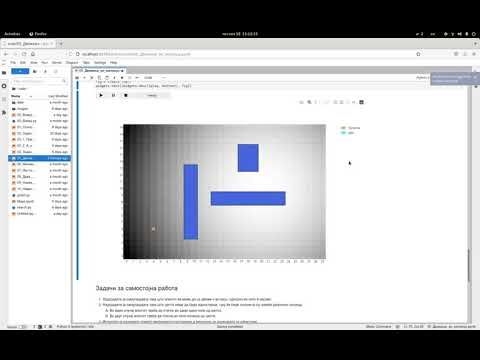

In [35]:
YouTubeVideo('io5GkVwXnAE')